In [1]:
import sys
sys.path.insert(1, '/Users/labadmin/Projects/immusign')
import shutil
import os.path

In [2]:
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
np.float = float
np.bool = bool
np.int = int
import matplotlib.pyplot as plt
import seaborn as sns
import random
import torch
import time
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
import utils
import shap
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


# Read Filereport

In [4]:
filereport = pd.read_csv("intega/filereport_read_run_PRJEB55475_tsv.txt",delim_whitespace=True)
filereport["filenames"] = filereport["sra_ftp"].apply(lambda x: "_".join(x.split("/")[-1].split(".")[0].split("_")[0:2]))
filereport["stripped_patient_id"] = filereport["filenames"].apply(utils.get_stripped_pat_no)

In [7]:
for file in tqdm(filereport.filenames):
    file_name = file + ".clones.txt"
    dest_path = "intega/Intega_final/"
    src_path = "intega/Intega/"
    if not os.path.exists(dest_path + file_name):
        shutil.copy2( src_path + file_name, dest_path)

  0%|          | 0/146 [00:00<?, ?it/s]

# Load Data read from R-Script

In [3]:
import rpy2.robjects as robjects
robjects.r['load']("intega/intega_not_normalized_with_out_of_frame.RData")
twb = robjects.r['twb']

In [4]:
df = utils.convert_rtwb_to_pdtwb(twb)

In [5]:
df["clones.txt.name"] = df["sample"].apply(lambda x: x + ".clones.txt")

# Add metric info

In [6]:
stats = pd.read_csv("intega/output/stats.csv", sep=";")
stats.rename(columns={stats.columns[0]:"sample"}, inplace=True)

In [7]:
df = df.merge(stats.iloc[:-2], on = "sample")

In [8]:
len(df["clones.txt.name"].unique())

146

# Get meta info

## get disposition data

In [9]:
xl_file = pd.ExcelFile("intega/disposition_2022-07-01.xlsx")

dfs = {sheet_name: xl_file.parse(sheet_name) 
          for sheet_name in xl_file.sheet_names}
disposition = dfs["disposition"]

In [10]:
disposition.columns

Index(['Pat-No.', 'Age [y]', 'Gender (M/F)', 'Random No.',
       'Treatment as Randomized', 'Treatment as Treated',
       'Prior Surgery (Yes/No)', 'HER2 Status Local (IHC 2+/3+)',
       'HER2 Status Central', 'Tumor Proportion Score', 'Immune Cell Score',
       'Combined Positive Score', 'Prior Drug Therapy',
       'Therapy Duration, Any Component [mo]',
       'Therapy Duration, All Scheduled Components [mo]',
       'Therapy Duration, Nivolumab [mo]', 'Reason for End of Treatment',
       'Overall Best Response (CR/PR)', 'Time to Best Response [mo]',
       'Response at 1st Tumor Assessment (PD/SD/PR/CR/NA)',
       'Sum of Target Lesion Diameters [mm] at Screening',
       '% Change of Diameters (target lesions) at 1st Tumor Assessment',
       'Best % Change of Diameters (Taget Lesions) during Tumor Assessments',
       'PFS [mo]', 'Censoring (Yes/No)', 'No of AEs (Grade 3-5)', 'No of SAEs',
       'OS [mo]', 'Death (Yes/No)'],
      dtype='object')

## get results data

In [42]:
xl_file = pd.ExcelFile("intega/Ergebnisse_CDC_Her2_Aug2021_TRB.Immun_Metriken_INTEGA.xlsx")

dfs = {sheet_name: xl_file.parse(sheet_name) 
          for sheet_name in xl_file.sheet_names}
Ergebnisse_CDC_Her2 = dfs["Ergebnisse_CDC_Her2_Aug2021_INT"]
Ergebnisse_CDC_Her2.columns = Ergebnisse_CDC_Her2.iloc[0]
Ergebnisse_CDC_Her2 = Ergebnisse_CDC_Her2.iloc[1:].copy()


new_colums = [ 'Zentrum',              'Pat-ID',
                'Patient-ID',               'Probe',                   np.nan,
             'Probenabnahme',       'Datum_Analyse',                'CTC1',
                    'HER2-0',              'HER2-1',              'HER2-2',
                    'HER2-3',                 'CXC',             'PD-L1-0',
                   'PD-L1-1',             'PD-L1-2',             'PD-L1-3',
                'Kommentare1',                   "Kommentare2",                   "Kommentare3",
                         np.nan,                  'ID',           'all.names',
                 'Clonality',               'Group',           'Diversity',
                     'Group',            'Richness',               'Group']
Ergebnisse_CDC_Her2.columns = new_colums

In [43]:
Ergebnisse_CDC_Her2

,Zentrum,Pat-ID,Patient-ID,Probe,NaN,Probenabnahme,Datum_Analyse,CTC1,HER2-0,HER2-1,...,Kommentare3,NaN,ID,all.names,Clonality,Group,Diversity,Group,Richness,Group
1,1,1,0001-001,Baseline,1.0,2018-03-08 00:00:00,2018-03-13 00:00:00,1,NaN,NaN,...,NaN,BL29,0001-001,Svenja-TRB-0001-001-BL-INTEGA_S100,0.094284,BL,9.551617,BL,1495,BL
2,1,1,0001-001,1Tag2Zyk,2.0,2018-04-05 00:00:00,2018-04-09 00:00:00,0,NaN,NaN,...,NaN,C24,0001-001,Svenja-TRB-0001-001-C2-INTEGA_S101,0.08677,C2,9.816343,C2,1721,C2
3,1,1,0001-001,1Tag4-5,3.0,2018-06-04 00:00:00,2018-06-06 00:00:00,0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1,1,0001-001,ProEnd,4.0,2018-11-29 00:00:00,2018-11-30 00:00:00,1,1,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,1,2,0001-002,Baseline,1.0,2019-02-22 00:00:00,2019-02-26 00:00:00,5,5,NaN,...,NaN,BL23,0001-002,Svenja-TRB-0001-002-BL-INTEGA_S79,0.082909,BL,9.154001,BL,1011,BL
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
226,38,5,0038-005,1Tag4-5,3.0,2020-04-01 00:00:00,2020-04-06 00:00:00,142,130,12,...,NaN,NaN,0038-005,NaN,0.124895,C2,8.294035,C2,713,C2
227,39,1,0039-001,Baseline,1.0,2019-11-21 00:00:00,2019-11-22 00:00:00,0,NaN,NaN,...,NaN,NaN,0039-001,NC-hs-TRB-0039-001-Baseline-PB-gDNA_S66,0.053723,BL,10.474131,BL,2148,BL
228,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
229,39,1,0039-001,ProEnd,4.0,2020-01-28 00:00:00,2020-01-30 00:00:00,0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## get probe review

In [12]:
xl_file = pd.ExcelFile("intega/Probenübersicht Sequenzierungsstatus Intega-Studie alle Zeitpunkte_LP.xlsx")

proben_df = {sheet_name: xl_file.parse(sheet_name) 
          for sheet_name in xl_file.sheet_names}
proben_df = proben_df["Probe_vorhanden"]

In [267]:
proben_df.keys()

Index(['Status', 'Patient', 'Tumorproben', 'Tumor', 'BL', 'C2', 'C5', 'EOT/PD',
       'Notizen', 'Cycle_EOT', 'Datum BL', 'Datum C2_sample',
       'Datum C5_sample', 'Datum EOT_sample', 'Datum_EOT_real',
       'week C2 sample', 'week C5 sample', 'week EOT sample',
       'week_to_EOT_C2_sample', 'week_to_EOT_C5_sample',
       'week_to_EOT_EOT_sample', 'Unnamed: 21', 'ja: Probe vorhanden'],
      dtype='object')

# Merge meta info

## merge dispistion 

In [13]:
df["stripped_patient_id"] = df["sample"].apply(utils.get_stripped_pat_no)

In [14]:
disposition["stripped_patient_id"] = disposition["Pat-No."].apply(utils.get_stripped_pat_no)

In [15]:
print("Patients not in disposition: ", set(df["stripped_patient_id"].unique()).difference(set(disposition["stripped_patient_id"].unique())))
print("Patients not in twb data: ", set(disposition["stripped_patient_id"].unique()).difference(set(df["stripped_patient_id"].unique())))

Patients not in disposition:  {'38-1'}
Patients not in twb data:  {'1-3', '15-4', '35-5'}


In [16]:
df = df.merge(disposition, on = "stripped_patient_id", how = "left")

## merge results

In [66]:
Ergebnisse_CDC_Her2.columns

Index([      'Zentrum',        'Pat-ID',    'Patient-ID',         'Probe',
                   nan, 'Probenabnahme', 'Datum_Analyse',          'CTC1',
              'HER2-0',        'HER2-1',        'HER2-2',        'HER2-3',
                 'CXC',       'PD-L1-0',       'PD-L1-1',       'PD-L1-2',
             'PD-L1-3',   'Kommentare1',   'Kommentare2',   'Kommentare3',
                   nan,            'ID',     'all.names',     'Clonality',
               'Group',     'Diversity',         'Group',      'Richness',
               'Group'],
      dtype='object')

In [155]:
str(None)

'None'

In [44]:
Ergebnisse_CDC_Her2["stripped_patient_id"] = Ergebnisse_CDC_Her2["all.names"].apply(utils.get_stripped_pat_no)
Ergebnisse_CDC_Her2["Probe_cleaned"] = Ergebnisse_CDC_Her2["Probe"].apply(lambda x: "BL" if x in ["Baseline", "BL"] 
                                                                          else ( "C2" if "2Zyk" in str(x) else x))

In [45]:
Ergebnisse_CDC_Her2.loc[Ergebnisse_CDC_Her2["stripped_patient_id"].isnull(), "stripped_patient_id"] = Ergebnisse_CDC_Her2.loc[Ergebnisse_CDC_Her2["stripped_patient_id"].isnull(), "Patient-ID"].apply(utils.get_stripped_pat_no)

In [46]:
print("Patients not in results: ", set(df["stripped_patient_id"].unique()).difference(set(Ergebnisse_CDC_Her2["stripped_patient_id"].unique())))
print("Patients not in twb data: ", set(Ergebnisse_CDC_Her2["stripped_patient_id"].unique()).difference(set(df["stripped_patient_id"].unique())))

Patients not in results:  set()
Patients not in twb data:  {'3-19', '1-3', '9-1', '15-8', '1-6', None}


In [47]:
Ergebnisse_per_probe_patient = Ergebnisse_CDC_Her2.groupby(["Probe_cleaned", "stripped_patient_id"]).apply(len).reset_index()

In [48]:
Ergebnisse_per_probe_patient[Ergebnisse_per_probe_patient[0] > 1] 

,Probe_cleaned,stripped_patient_id,0
6,1Tag4-5,16-3,2
20,1Tag4-5,38-1,2
32,BL,12-1,2
54,BL,2-11,2
77,BL,27-2,2
103,BL,6-2,2
108,BL,7-6,2
126,C2,16-3,2
131,C2,2-10,2
140,C2,2-5,2


In [49]:
double_probe_patient = Ergebnisse_per_probe_patient[Ergebnisse_per_probe_patient[0] > 1][["Probe_cleaned", "stripped_patient_id"]]

### mehrere ergebnisse für gleiche patienten --> filereport_read_run_PRJEB55475_tsv

In [50]:
filereport = pd.read_csv("intega/filereport_read_run_PRJEB55475_tsv.txt",delim_whitespace=True)

In [51]:
filereport.head()

,run_accession,sample_accession,experiment_accession,study_accession,tax_id,scientific_name,fastq_ftp,submitted_ftp,sra_ftp
0,ERR10747912,SAMEA112286929,ERX10200346,PRJEB55475,9606,Homo,sapiens,ftp.sra.ebi.ac.uk/vol1/fastq/ERR107/012/ERR107...,ftp.sra.ebi.ac.uk/vol1/run/ERR107/ERR10747912/...
1,ERR10747914,SAMEA112286931,ERX10200348,PRJEB55475,9606,Homo,sapiens,ftp.sra.ebi.ac.uk/vol1/fastq/ERR107/014/ERR107...,ftp.sra.ebi.ac.uk/vol1/run/ERR107/ERR10747914/...
2,ERR10747915,SAMEA112286932,ERX10200349,PRJEB55475,9606,Homo,sapiens,ftp.sra.ebi.ac.uk/vol1/fastq/ERR107/015/ERR107...,ftp.sra.ebi.ac.uk/vol1/run/ERR107/ERR10747915/...
3,ERR10747916,SAMEA112286933,ERX10200350,PRJEB55475,9606,Homo,sapiens,ftp.sra.ebi.ac.uk/vol1/fastq/ERR107/016/ERR107...,ftp.sra.ebi.ac.uk/vol1/run/ERR107/ERR10747916/...
4,ERR10747919,SAMEA112286936,ERX10200353,PRJEB55475,9606,Homo,sapiens,ftp.sra.ebi.ac.uk/vol1/fastq/ERR107/019/ERR107...,ftp.sra.ebi.ac.uk/vol1/run/ERR107/ERR10747919/...


In [52]:
filereport["filenames"] = filereport["sra_ftp"].apply(lambda x: x.split("/")[-1].split(".")[0])

In [53]:
filereport["stripped_patient_id"] = filereport["filenames"].apply(utils.get_stripped_pat_no)

In [54]:
for i, row in double_probe_patient.iterrows(): 
    id = row.stripped_patient_id
    probe = row.Probe_cleaned
    print(id, probe)
    if probe == "Baseline":
        probe = ["Baseline", "BL"]
    else:
        probe = [probe]
    
    filename_id = filereport[filereport["stripped_patient_id"] == id]["filenames"]
    print(list(filename_id))
    for file in filename_id:
        for p in probe:
            if p in file:
                print("Match: ",file)
    print("\n")

16-3 1Tag4-5
['NC-hs-TRB-0016-003-2-Zyklus-PB-gDNA_S32_L001_R2_001', 'Dona-hs-TRB-016-003-PB-Baseline-gDNA_S124_L001_R2_001']


38-1 1Tag4-5
['NC-hs-TRB-0038-001-Baseline-PB-gDNA_S11_L001_R2_001', 'NC-hs-TRB-0038-001-2-Zyklus-PB-gDNA_S12_L001_R2_001']


12-1 BL
['NC-hs-TRB-0012-001-Baseline-PB-gDNA_S23_L001_R2_001', 'Svenja-TRB-0012-001-C2-INTEGA_S119_L001_R2_001']


2-11 BL
['NC-hs-TRB-0002-011-Baseline-PB-gDNA_S16_L001_R2_001', 'Svenja-TRB-0002-011-C2-INTEGA_S153_L001_R2_001']


27-2 BL
['Svenja-TRB-0027-002-C2-INTEGA_S141_L001_R2_001', 'Svenja-TRB-0027-002-BL-INTEGA_S140_L001_R2_001']
Match:  Svenja-TRB-0027-002-BL-INTEGA_S140_L001_R2_001


6-2 BL
['NC-hs-TRB-0006-002-Baseline-PB-gDNA_S18_L001_R2_001']


7-6 BL
['NC-hs-TRB-0007-006-Baseline-PB-gDNA_S22_L001_R2_001']


16-3 C2
['NC-hs-TRB-0016-003-2-Zyklus-PB-gDNA_S32_L001_R2_001', 'Dona-hs-TRB-016-003-PB-Baseline-gDNA_S124_L001_R2_001']


2-10 C2
['Svenja-TRB-0002-010-BL-INTEGA_S152_L001_R2_001', 'NC-hs-TRB-0002-010-2-Zyklus-PB-gDNA

In [ ]:
# 16-3 1Tag4-5, 38-1 1Tag4-5, 12-1 BL, 27-2 BL, 6-2 BL, 7-6 BL, 16-3 C2, 2-10 C2, 2-5 C2, 2-9 C2, 5-4 C2, 
# 7-3 C2, 7-4 C2, 7-5 C2

In [55]:
Ergebnisse_CDC_Her2.loc[110]

Zentrum                                                    NaN
Pat-ID                                                     NaN
Patient-ID                                            0012-001
Probe                                                       BL
NaN                                                        NaN
Probenabnahme                                              NaN
Datum_Analyse                                              NaN
CTC1                                                       NaN
HER2-0                                                     NaN
HER2-1                                                     NaN
HER2-2                                                     NaN
HER2-3                                                     NaN
CXC                                                        NaN
PD-L1-0                                                    NaN
PD-L1-1                                                    NaN
PD-L1-2                                                

In [56]:
idx_to_drop = [142, 217, 183]
# overwrite 109 with 110 
idx_to_overwrite = {109:110, 48:49, 85:86, 102:103, 140:141, 46:47, 31:32, 42:43, 73:74, 93:94, 96:97, 99:100}

### Overwrite rows with results found in file report

In [57]:
for i in idx_to_overwrite.keys():
    j = idx_to_overwrite[i]
    Ergebnisse_CDC_Her2.loc[i,'CTC1': 'Probe_cleaned'] = Ergebnisse_CDC_Her2.loc[j,'CTC1': 'Probe_cleaned']
    Ergebnisse_CDC_Her2.drop(j,inplace=True)

### Drop rows with double entry 

In [58]:
Ergebnisse_CDC_Her2.loc[idx_to_drop]

,Zentrum,Pat-ID,Patient-ID,Probe,NaN,Probenabnahme,Datum_Analyse,CTC1,HER2-0,HER2-1,...,ID,all.names,Clonality,Group,Diversity,Group,Richness,Group,stripped_patient_id,Probe_cleaned
142,16,3,0016-003,1Tag4-5,3.0,2018-08-16 00:00:00,2018-08-21 00:00:00,0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16-3,1Tag4-5
217,38,1,0038-001,1Tag4-5,3.0,2019-04-16 00:00:00,2019-04-18 00:00:00,0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,38-1,1Tag4-5
183,27,2,0027-002,Baseline,1.0,2019-03-13 00:00:00,2019-03-15 00:00:00,10,0,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,27-2,BL


In [59]:
Ergebnisse_CDC_Her2.drop(idx_to_drop, inplace=True)

In [60]:
Ergebnisse_CDC_Her2["clones.txt.name"] = Ergebnisse_CDC_Her2["all.names"].apply(lambda x: x + ".clones.txt" if not pd.isnull(x) else x)

In [61]:
df_results = df.merge(Ergebnisse_CDC_Her2, on = ["clones.txt.name", "stripped_patient_id"], how = "left")

In [62]:
len(df_results)

368123

In [63]:
df_results[["Clonality_x","Clonality_y"]]

,Clonality_x,Clonality_y
0,"0,230526164079581",0.225941
1,"0,230526164079581",0.225941
2,"0,230526164079581",0.225941
3,"0,230526164079581",0.225941
4,"0,230526164079581",0.225941
...,...,...
368118,"0,0733509336567334",0.058543
368119,"0,0733509336567334",0.058543
368120,"0,0733509336567334",0.058543
368121,"0,0733509336567334",0.058543


## merge proben

In [64]:
proben_df

,Status,Patient,Tumorproben,Tumor,BL,C2,C5,EOT/PD,Notizen,Cycle_EOT,...,Datum EOT_sample,Datum_EOT_real,week C2 sample,week C5 sample,week EOT sample,week_to_EOT_C2_sample,week_to_EOT_C5_sample,week_to_EOT_EOT_sample,Unnamed: 21,ja: Probe vorhanden
0,NaN,0001-001,1 Paraffinblock,seq,seq,seq,seq,seq,NaN,C16,...,2018-11-29 00:00:00,2018-11-29 00:00:00,4.0,13.0,38.0,-34.0,-26.0,0.0,NaN,NA: Probe nicht vorhanden
1,NaN,0001-002,1 Paraffinblock,seq,seq,seq,seq,seq,NaN,C19,...,2019-11-28 00:00:00,2019-11-28 00:00:00,3.0,9.0,40.0,-38.0,-32.0,0.0,NaN,seq: Probe vorhanden und sequenziert mit GeneP...
2,NaN,0001-003,1 Paraffinblock,seq,?,cf,Plasma,seq,"BL, C2 und C5 als 0038-001 beschriftet, Patien...",C16,...,2019-10-15 00:00:00,2019-10-15 00:00:00,3.0,9.0,35.0,-32.0,-26.0,0.0,NaN,"cf: cfDNA isoliert, aber noch nicht mit GenePa..."
3,NaN,0001-004,1 Parafinblock,seq,seq,seq,seq,NaN,NaN,C24,...,NaN,2020-09-15 00:00:00,4.0,13.0,54.0,-51.0,-42.0,NaN,NaN,"g: gDNA isoliert, noch kein Gene Panel erstell..."
4,NaN,0002-001,1 Parafinblock,seq,seq,seq,NaN,NaN,NaN,C14,...,NaN,2018-10-10 00:00:00,3.0,NaN,31.0,-28.0,NaN,NaN,NaN,"Panel: PanelUPCR bereits erstellt, jedoch noch..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
93,NaN,0038-002,1 Paraffinblock,seq,seq,seq,seq,seq,NaN,C31,...,2020-11-03 00:00:00,2020-11-03 00:00:00,3.0,12.0,64.0,-61.0,-52.0,0.0,NaN,NaN
94,NaN,0038-003,1 Paraffinblock,seq,seq,cf,NaN,seq,C3 statt C2,C7,...,2020-01-21 00:00:00,2020-01-21 00:00:00,9.0,NaN,22.0,-13.0,NaN,0.0,NaN,NaN
95,NaN,0038-004,1 Paraffinblock,seq,seq,EOT,NaN,seq,NaN,C2,...,2019-12-11 00:00:00,2019-12-11 00:00:00,NaN,NaN,3.0,NaN,NaN,0.0,NaN,NaN
96,NaN,0038-005,1 Paraffinblock,seq,seq,Panel,NaN,NaN,NaN,C3,...,NaN,2020-04-15 00:00:00,3.0,NaN,5.0,-2.0,NaN,NaN,NaN,NaN


In [65]:
df_results.columns

Index([               'Umi.count',           'Umi.proportion',
                     'Read.count',          'Read.proportion',
       'CDR3.nucleotide.sequence', 'CDR3.amino.acid.sequence',
                         'V.gene',                   'J.gene',
                         'D.gene',                    'V.end',
       ...
                              nan,                       'ID',
                      'all.names',              'Clonality_y',
                          'Group',                'Diversity',
                          'Group',                 'Richness',
                          'Group',            'Probe_cleaned'],
      dtype='object', length=103)

In [66]:
proben_df["stripped_patient_id"] = proben_df["Patient"].apply(utils.get_stripped_pat_no)

In [67]:
print("Patients not in disposition: ", set(df_results["stripped_patient_id"].unique()).difference(set(proben_df["stripped_patient_id"].unique())))
print("Patients not in twb data: ", set(proben_df["stripped_patient_id"].unique()).difference(set(df_results["stripped_patient_id"].unique())))

Patients not in disposition:  set()
Patients not in twb data:  {'5-5', '22-5', '15-4', '1-3', '9-1', '32-2', '15-8', '35-4', '35-5', '33-2', '16-4', '24-1'}


In [68]:
df_results = df_results.merge(proben_df, on = ["stripped_patient_id"], how = "left")

In [69]:
df_results.head()

,Umi.count,Umi.proportion,Read.count,Read.proportion,CDR3.nucleotide.sequence,CDR3.amino.acid.sequence,V.gene,J.gene,D.gene,V.end,...,Datum EOT_sample,Datum_EOT_real,week C2 sample,week C5 sample,week EOT sample,week_to_EOT_C2_sample,week_to_EOT_C5_sample,week_to_EOT_EOT_sample,Unnamed: 21,ja: Probe vorhanden
0,22802,0.205514,22802,0.205514,TGCAGCGTTGAAGGTGGGACGCGCAATGAGCAGTTCTTC,CSVEGGTRNEQFF,TRBV29-1,TRBJ2-1,"TRBD1, TRBD2",195,...,NaN,2018-10-10 00:00:00,3.0,NaN,31.0,-28.0,NaN,NaN,NaN,"Panel: PanelUPCR bereits erstellt, jedoch noch..."
1,2577,0.023226,2577,0.023226,TGTGCCAAAAATATTGGAGGTGACACCGGGGAGCTGTTTTTT,CAKNIGGDTGELFF,TRBV30,TRBJ2-2,TRBD2,177,...,NaN,2018-10-10 00:00:00,3.0,NaN,31.0,-28.0,NaN,NaN,NaN,"Panel: PanelUPCR bereits erstellt, jedoch noch..."
2,1961,0.017674,1961,0.017674,TGCAGCGACCCGACGGTATGCCGGACGACGCCACCGGGGAGCTGTT...,CSDPTVCR~DATGELFF,TRBV29-1,TRBJ2-2,,189,...,NaN,2018-10-10 00:00:00,3.0,NaN,31.0,-28.0,NaN,NaN,NaN,"Panel: PanelUPCR bereits erstellt, jedoch noch..."
3,990,0.008923,990,0.008923,TGTGCCAGCAGTGAGGGGAGCGGGAGTGGCACAGATACGCAGTATTTT,CASSEGSGSGTDTQYF,TRBV6-1,TRBJ2-3,TRBD2,190,...,NaN,2018-10-10 00:00:00,3.0,NaN,31.0,-28.0,NaN,NaN,NaN,"Panel: PanelUPCR bereits erstellt, jedoch noch..."
4,885,0.007976,885,0.007976,TGTGCCAGCAGTGAAGGGGCCGGGGCCAACGTCCTGACTTTC,CASSEGAGANVLTF,TRBV6-1,TRBJ2-6,TRBD2,192,...,NaN,2018-10-10 00:00:00,3.0,NaN,31.0,-28.0,NaN,NaN,NaN,"Panel: PanelUPCR bereits erstellt, jedoch noch..."


In [291]:
#df_results.to_pickle("intega/intega_40000_reads_with_out_of_frame_merged_dispo_results_proben.pkl")

# Load raw file info

In [70]:
df_raw = utils.read_clones_txt(np.unique(df["clones.txt.name"].values), "intega/Intega_final")

  0%|          | 0/146 [00:00<?, ?it/s]

In [295]:
df_results.columns

Index([               'Umi.count',           'Umi.proportion',
                     'Read.count',          'Read.proportion',
       'CDR3.nucleotide.sequence', 'CDR3.amino.acid.sequence',
                         'V.gene',                   'J.gene',
                         'D.gene',                    'V.end',
       ...
               'Datum EOT_sample',           'Datum_EOT_real',
                 'week C2 sample',           'week C5 sample',
                'week EOT sample',    'week_to_EOT_C2_sample',
          'week_to_EOT_C5_sample',   'week_to_EOT_EOT_sample',
                    'Unnamed: 21',      'ja: Probe vorhanden'],
      dtype='object', length=126)

In [296]:
df_raw.columns

Index(['cloneId', 'cloneCount', 'cloneFraction', 'nSeqCDR3', 'aaSeqCDR3',
       'bestVGene', 'bestDGene', 'bestJGene', 'vBestIdentityPercent',
       'lengthOfCDR3', 'targetSequences', 'allVGenes', 'allDGenes',
       'allJGenes', 'allVHits', 'allDHits', 'allJHits', 'allVAlignments',
       'allDAlignments', 'allJAlignments', 'clones.txt.name'],
      dtype='object')

## Add correct clone Id before adding info from raw files

In [71]:
for file in tqdm(df_results["clones.txt.name"].unique()):
    df_sub_file = df_results[df_results["clones.txt.name"] == file]
    df_raw_sub_file = df_raw[df_raw["clones.txt.name"] == file]
    for i, index_row in enumerate(df_sub_file.iterrows()):
        index, row = index_row[0], index_row[1]  
        if row["CDR3.nucleotide.sequence"] == df_raw_sub_file.iloc[i]["nSeqCDR3"]:
            df_results.loc[index,"cloneId"] = df_raw_sub_file.iloc[i]["cloneId"]

  0%|          | 0/146 [00:00<?, ?it/s]

In [72]:
df_results2 = df_results.merge(df_raw, left_on=["clones.txt.name", "cloneId", "CDR3.nucleotide.sequence"], right_on =["clones.txt.name", "cloneId", "nSeqCDR3"], how = "left")

In [305]:
#df_results2.to_pickle("intega/intega_40000_reads_with_out_of_frame_merged_dispo_results_proben_raw_data.pkl")

In [307]:
list(df_results2.columns)

['Umi.count',
 'Umi.proportion',
 'Read.count',
 'Read.proportion',
 'CDR3.nucleotide.sequence',
 'CDR3.amino.acid.sequence',
 'V.gene',
 'J.gene',
 'D.gene',
 'V.end',
 'J.start',
 'D5.end',
 'D3.end',
 'VD.insertions',
 'DJ.insertions',
 'Total.insertions',
 'sample',
 'cloneId',
 'clones.txt.name',
 '#Nucleotide clones',
 '#Aminoacid clonotypes',
 '%Aminoacid clonotypes',
 '#In-frames',
 '%In-frames',
 '#Out-of-frames',
 '%Out-of-frames',
 'Sum.reads',
 'Min.reads',
 '1st Qu.reads',
 'Median.reads',
 'Mean.reads',
 '3rd Qu.reads',
 'Max.reads',
 'Sum.UMIs',
 'Min.UMIs',
 '1st Qu.UMIs',
 'Median.UMIs',
 'Mean.UMIs',
 '3rd Qu.UMIs',
 'Max.UMIs',
 'Clonality_x',
 'twb.shannon',
 'twb.simp',
 'stripped_patient_id',
 'Pat-No.',
 'Age [y]',
 'Gender (M/F)',
 'Random No.',
 'Treatment as Randomized',
 'Treatment as Treated',
 'Prior Surgery (Yes/No)',
 'HER2 Status Local (IHC 2+/3+)',
 'HER2 Status Central',
 'Tumor Proportion Score',
 'Immune Cell Score',
 'Combined Positive Score',
 'Pri

# Get rid of redundant information

In [73]:
df_results2.drop(columns = ['Umi.count', 'Umi.proportion', 'Sum.UMIs', 'Min.UMIs', '1st Qu.UMIs',
       'Median.UMIs', 'Mean.UMIs', '3rd Qu.UMIs', 'Max.UMIs', 'nSeqCDR3'],inplace=True)

In [76]:
list(df_results2.columns)

['Read.count',
 'Read.proportion',
 'CDR3.nucleotide.sequence',
 'CDR3.amino.acid.sequence',
 'V.gene',
 'J.gene',
 'D.gene',
 'V.end',
 'J.start',
 'D5.end',
 'D3.end',
 'VD.insertions',
 'DJ.insertions',
 'Total.insertions',
 'sample',
 'cloneId',
 'clones.txt.name',
 '#Nucleotide clones',
 '#Aminoacid clonotypes',
 '%Aminoacid clonotypes',
 '#In-frames',
 '%In-frames',
 '#Out-of-frames',
 '%Out-of-frames',
 'Sum.reads',
 'Min.reads',
 '1st Qu.reads',
 'Median.reads',
 'Mean.reads',
 '3rd Qu.reads',
 'Max.reads',
 'Clonality_x',
 'twb.shannon',
 'twb.simp',
 'stripped_patient_id',
 'Pat-No.',
 'Age [y]',
 'Gender (M/F)',
 'Random No.',
 'Treatment as Randomized',
 'Treatment as Treated',
 'Prior Surgery (Yes/No)',
 'HER2 Status Local (IHC 2+/3+)',
 'HER2 Status Central',
 'Tumor Proportion Score',
 'Immune Cell Score',
 'Combined Positive Score',
 'Prior Drug Therapy',
 'Therapy Duration, Any Component [mo]',
 'Therapy Duration, All Scheduled Components [mo]',
 'Therapy Duration, Niv

In [77]:
df_results2[['Pat-No.','Pat-ID','Patient-ID', 'Probe', 'ID', 'all.names', 'Group',
 'Probe_cleaned', 'Patient']]

,Pat-No.,Pat-ID,Patient-ID,Probe,ID,all.names,Group,Group,Group,Probe_cleaned,Patient
0,0002-001,1,0002-001,Baseline,002-001,Dona-hs-TRB-002-001-PB-Baseline-gDNA_S111,BL,BL,BL,BL,0002-001
1,0002-001,1,0002-001,Baseline,002-001,Dona-hs-TRB-002-001-PB-Baseline-gDNA_S111,BL,BL,BL,BL,0002-001
2,0002-001,1,0002-001,Baseline,002-001,Dona-hs-TRB-002-001-PB-Baseline-gDNA_S111,BL,BL,BL,BL,0002-001
3,0002-001,1,0002-001,Baseline,002-001,Dona-hs-TRB-002-001-PB-Baseline-gDNA_S111,BL,BL,BL,BL,0002-001
4,0002-001,1,0002-001,Baseline,002-001,Dona-hs-TRB-002-001-PB-Baseline-gDNA_S111,BL,BL,BL,BL,0002-001
...,...,...,...,...,...,...,...,...,...,...,...
368118,0035-002,2,0035-002,Baseline,0035-002,Svenja-TRB-0035-002-BL-INTEGA_S146,BL,BL,BL,BL,0035-002
368119,0035-002,2,0035-002,Baseline,0035-002,Svenja-TRB-0035-002-BL-INTEGA_S146,BL,BL,BL,BL,0035-002
368120,0035-002,2,0035-002,Baseline,0035-002,Svenja-TRB-0035-002-BL-INTEGA_S146,BL,BL,BL,BL,0035-002
368121,0035-002,2,0035-002,Baseline,0035-002,Svenja-TRB-0035-002-BL-INTEGA_S146,BL,BL,BL,BL,0035-002


In [78]:
df_results2.drop(columns = ['Pat-No.','Pat-ID','Patient-ID','ID', 'all.names', 'Group','Patient'],inplace=True)

In [79]:
df_results2[['Clonality_x',
 'twb.shannon',
 'twb.simp','Clonality_y','Diversity', 'Richness',]]

,Clonality_x,twb.shannon,twb.simp,Clonality_y,Diversity,Richness
0,"0,230526164079581","8,33318829492124","22,6204701668475",0.225941,7.659172,952
1,"0,230526164079581","8,33318829492124","22,6204701668475",0.225941,7.659172,952
2,"0,230526164079581","8,33318829492124","22,6204701668475",0.225941,7.659172,952
3,"0,230526164079581","8,33318829492124","22,6204701668475",0.225941,7.659172,952
4,"0,230526164079581","8,33318829492124","22,6204701668475",0.225941,7.659172,952
...,...,...,...,...,...,...
368118,"0,0733509336567334","10,3883581338002","547,416817282941",0.058543,10.011364,1589
368119,"0,0733509336567334","10,3883581338002","547,416817282941",0.058543,10.011364,1589
368120,"0,0733509336567334","10,3883581338002","547,416817282941",0.058543,10.011364,1589
368121,"0,0733509336567334","10,3883581338002","547,416817282941",0.058543,10.011364,1589


In [80]:
df_results2.rename(columns={"Clonality_x" : "Clonality", 
                            "Clonality_y" : "Clonality_results",
                           "Diversity" : "Diversity_results", 
                           "Richness" : "Richness_results"}, inplace=True)

In [120]:
df_results2["has_mutation"] = df_results2["aaSeqCDR3"].apply(lambda x: "_" in x or "*" in x)
df_results2["Clonality"] = df_results2["Clonality"].apply(lambda x: float(x.replace(",",".").replace("+","-")) if type(x) == str else float(x))
df_results2["twb.shannon"] = df_results2["twb.shannon"].apply(lambda x: float(x.replace(",",".").replace("+","-")) if type(x) == str else float(x))
df_results2["twb.simp"] = df_results2["twb.simp"].apply(lambda x: float(x.replace(",",".").replace("+","-")) if type(x) == str else float(x))

In [81]:
df_results2.to_pickle("intega/intega_not_normalized_with_out_of_frame_merged_dispo_results_proben_raw_data_cleaned.pkl")

# Small Analysis

In [123]:
df = pd.read_pickle("intega/intega_not_normalized_with_out_of_frame_merged_dispo_results_proben_raw_data_cleaned.pkl")

In [124]:
np.asarray(df.columns)

array(['Read.count', 'Read.proportion', 'CDR3.nucleotide.sequence',
       'CDR3.amino.acid.sequence', 'V.gene', 'J.gene', 'D.gene', 'V.end',
       'J.start', 'D5.end', 'D3.end', 'VD.insertions', 'DJ.insertions',
       'Total.insertions', 'sample', 'cloneId', 'clones.txt.name',
       '#Nucleotide clones', '#Aminoacid clonotypes',
       '%Aminoacid clonotypes', '#In-frames', '%In-frames',
       '#Out-of-frames', '%Out-of-frames', 'Sum.reads', 'Min.reads',
       '1st Qu.reads', 'Median.reads', 'Mean.reads', '3rd Qu.reads',
       'Max.reads', 'Clonality', 'twb.shannon', 'twb.simp',
       'stripped_patient_id', 'Age [y]', 'Gender (M/F)', 'Random No.',
       'Treatment as Randomized', 'Treatment as Treated',
       'Prior Surgery (Yes/No)', 'HER2 Status Local (IHC 2+/3+)',
       'HER2 Status Central', 'Tumor Proportion Score',
       'Immune Cell Score', 'Combined Positive Score',
       'Prior Drug Therapy', 'Therapy Duration, Any Component [mo]',
       'Therapy Duration, All Sc

<Axes: xlabel='Death (Yes/No)', ylabel='Count'>

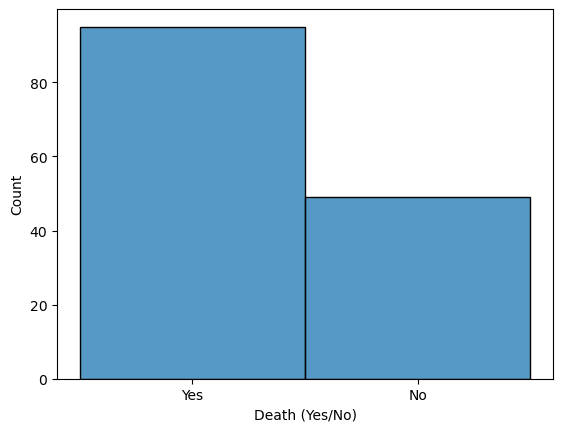

In [125]:
sns.histplot(df.groupby("clones.txt.name").first().reset_index()["Death (Yes/No)"])

<Axes: xlabel='OS [mo]', ylabel='Count'>

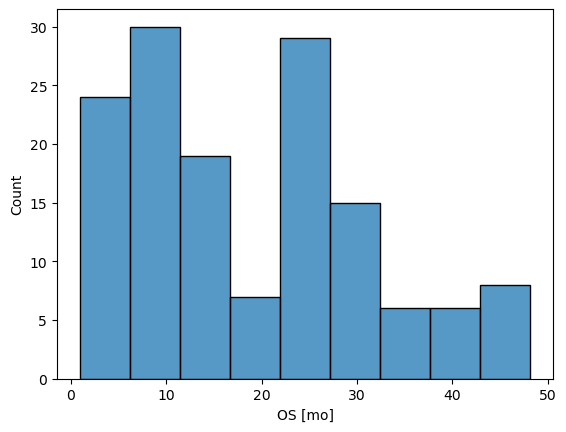

In [126]:
sns.histplot(df.groupby("clones.txt.name").first().reset_index()["OS [mo]"])

<Axes: xlabel='Age [y]', ylabel='Count'>

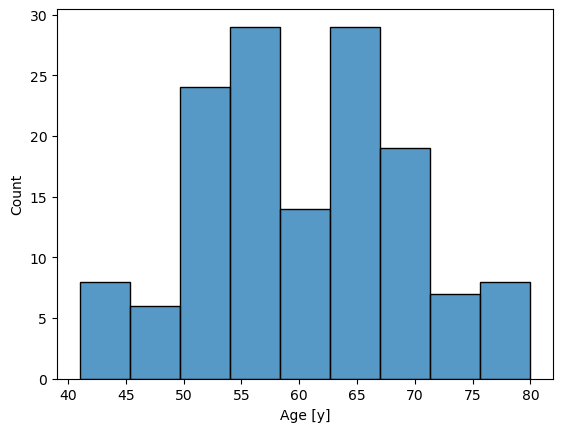

In [127]:
sns.histplot(df.groupby("clones.txt.name").first().reset_index()['Age [y]'])

<Axes: xlabel='Gender (M/F)', ylabel='Count'>

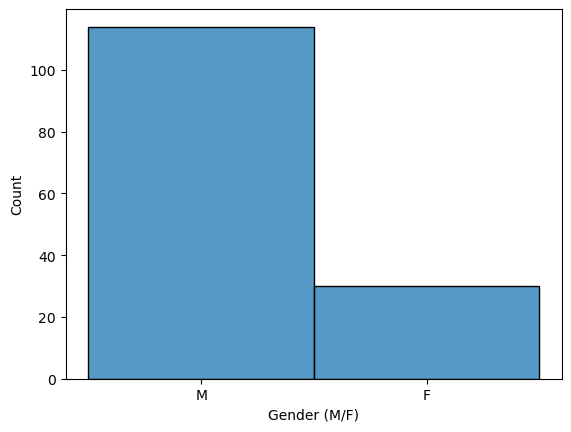

In [128]:
sns.histplot(df.groupby("clones.txt.name").first().reset_index()['Gender (M/F)'])

# Get missing Probe from file

In [129]:
missing_probe_files = df[df.Probe.isnull()]["clones.txt.name"].unique()

In [130]:
for file in missing_probe_files:
    if "Baseline" in file or "BL" in file:
        df.loc[df["clones.txt.name"] == file,"Probe"] = "BL"
        df.loc[df["clones.txt.name"] == file,"Probe_cleaned"] = "BL"
    elif "2-Zyklus" in file or "C2" in file:
        df.loc[df["clones.txt.name"] == file,"Probe"] = "C2"
        df.loc[df["clones.txt.name"] == file,"Probe_cleaned"] = "C2"
    elif "3-Zyklus" in file or "C3" in file:
        df.loc[df["clones.txt.name"] == file,"Probe"] = "C3"
        df.loc[df["clones.txt.name"] == file,"Probe_cleaned"] = "C3"

# Analyse Baseline Condition

In [132]:
df["Clonality"]

0         0.230526
1         0.230526
2         0.230526
3         0.230526
4         0.230526
            ...   
368118    0.073351
368119    0.073351
368120    0.073351
368121    0.073351
368122    0.073351
Name: Clonality, Length: 368123, dtype: float64

In [150]:
df_baseline = df[df["Probe_cleaned"] == "BL"].copy()

In [134]:
mutations_per_patient = df_baseline[df_baseline.has_mutation].groupby("clones.txt.name").apply(len).reset_index()
total_per_patient = df_baseline.groupby("clones.txt.name").apply(len).reset_index()

In [135]:
mutations_per_patient = mutations_per_patient.merge(total_per_patient, on="clones.txt.name",how="left")
mutations_per_patient = mutations_per_patient.merge(df_baseline[["clones.txt.name","Death (Yes/No)"]], on="clones.txt.name", how="left")

In [136]:
mutations_per_patient["non-productive AA (%)"] = mutations_per_patient["0_x"]/mutations_per_patient["0_y"] * 100

In [137]:
mutations_per_patient.sort_values(by="Death (Yes/No)", inplace = True)

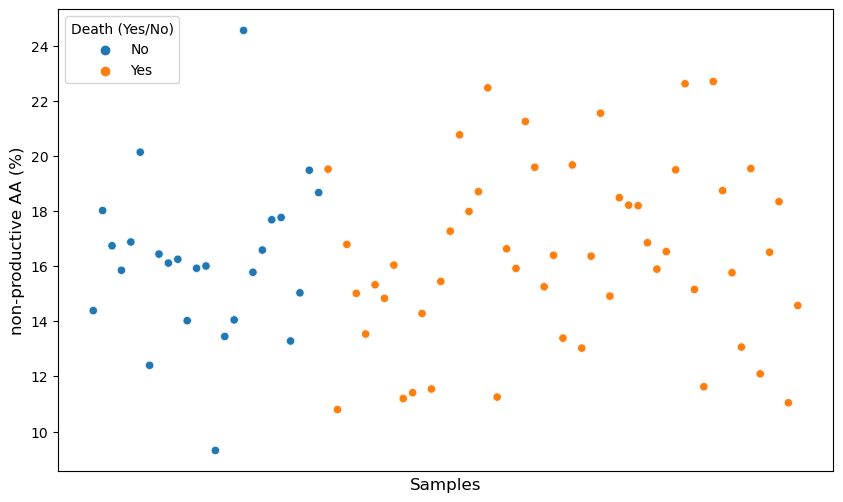

In [138]:
fig, ax = plt.subplots(figsize=(10, 6))
sns.scatterplot(x='clones.txt.name', y='non-productive AA (%)', hue='Death (Yes/No)', data=mutations_per_patient) 
ax.set_xticks([])
ax.set_ylabel("non-productive AA (%)", size=12)
ax.set_xlabel("Samples", size=12)
ax.legend(title='Death (Yes/No)')
plt.show()

# Classification

In [306]:
df_baseline = df[df["Probe_cleaned"] == "BL"].copy()

In [307]:
top_n_clones = 50

In [308]:
# Patient 0038-001 deleted
df_baseline[df_baseline["Death (Yes/No)"].isnull()]["clones.txt.name"].unique() 
#df_baseline[df_baseline["Age [y]"].isnull()]["clones.txt.name"].unique() 
#df_baseline[df_baseline["Gender (M/F)"].isnull()]["clones.txt.name"].unique()

array(['NC-hs-TRB-0038-001-Baseline-PB-gDNA_S11.clones.txt'], dtype=object)

In [309]:
df_baseline["HER2 Status Central"].unique()
#df_baseline["HER2 Status Local (IHC 2+/3+)"].unique()

array(['IHC 2+ and ISH amplified', 'IHC 3+', 'IHC 1', 'IHC 2', nan],
      dtype=object)

In [310]:
df_baseline.drop(list(df_baseline[df_baseline["Death (Yes/No)"].isnull()].index), inplace=True)

In [311]:
list(df_baseline.columns)

['Read.count',
 'Read.proportion',
 'CDR3.nucleotide.sequence',
 'CDR3.amino.acid.sequence',
 'V.gene',
 'J.gene',
 'D.gene',
 'V.end',
 'J.start',
 'D5.end',
 'D3.end',
 'VD.insertions',
 'DJ.insertions',
 'Total.insertions',
 'sample',
 'cloneId',
 'clones.txt.name',
 '#Nucleotide clones',
 '#Aminoacid clonotypes',
 '%Aminoacid clonotypes',
 '#In-frames',
 '%In-frames',
 '#Out-of-frames',
 '%Out-of-frames',
 'Sum.reads',
 'Min.reads',
 '1st Qu.reads',
 'Median.reads',
 'Mean.reads',
 '3rd Qu.reads',
 'Max.reads',
 'Clonality',
 'twb.shannon',
 'twb.simp',
 'stripped_patient_id',
 'Age [y]',
 'Gender (M/F)',
 'Random No.',
 'Treatment as Randomized',
 'Treatment as Treated',
 'Prior Surgery (Yes/No)',
 'HER2 Status Local (IHC 2+/3+)',
 'HER2 Status Central',
 'Tumor Proportion Score',
 'Immune Cell Score',
 'Combined Positive Score',
 'Prior Drug Therapy',
 'Therapy Duration, Any Component [mo]',
 'Therapy Duration, All Scheduled Components [mo]',
 'Therapy Duration, Nivolumab [mo]',


# Create Features

In [312]:
import importlib
importlib.reload(utils)

<module 'utils' from '/Users/labadmin/Projects/immusign/utils.py'>

In [313]:
X = utils.create_feature_df(df_baseline, target_column="Death (Yes/No)", 
    categorical_features=['bestVGene', 'bestDGene','bestJGene', 'has_mutation', 'HER2 Status Local (IHC 2+/3+)'],
    numerical_features=['Read.proportion', 'Clonality', 'twb.shannon', 'twb.simp'],
    top_n_clones = top_n_clones,
    features_to_encode_wide = ['bestVGene', 'bestDGene','bestJGene', 'Read.proportion', 'has_mutation'],
    file_id = "clones.txt.name",
    clone_id = "cloneId",
    wide_format =True, 
    keep_remaining_columns=False)                     

Created DataFrame with Features
Read.proportion_1 : 0.00 % NAN float64
Read.proportion_2 : 0.00 % NAN float64
Read.proportion_3 : 0.00 % NAN float64
Read.proportion_4 : 0.00 % NAN float64
Read.proportion_5 : 0.00 % NAN float64
Read.proportion_6 : 0.00 % NAN float64
Read.proportion_7 : 0.00 % NAN float64
Read.proportion_8 : 0.00 % NAN float64
Read.proportion_9 : 0.00 % NAN float64
Read.proportion_10 : 0.00 % NAN float64
Read.proportion_11 : 0.00 % NAN float64
Read.proportion_12 : 0.00 % NAN float64
Read.proportion_13 : 0.00 % NAN float64
Read.proportion_14 : 0.00 % NAN float64
Read.proportion_15 : 0.00 % NAN float64
Read.proportion_16 : 0.00 % NAN float64
Read.proportion_17 : 0.00 % NAN float64
Read.proportion_18 : 0.00 % NAN float64
Read.proportion_19 : 0.00 % NAN float64
Read.proportion_20 : 0.00 % NAN float64
Read.proportion_21 : 0.00 % NAN float64
Read.proportion_22 : 0.00 % NAN float64
Read.proportion_23 : 0.00 % NAN float64
Read.proportion_24 : 0.00 % NAN float64
Read.proportion_2

In [169]:
# Shannon = 0 --> Eveness = 0 -- > Clonality = 1 - evenness = 0
X.loc[X["Clonality"].isnull(),"Clonality"] = 1.0
# Evenness = shannon/HMAX --> hmax = 0 --> eveness = 0 --> Clonality = 1
X["Clonality"].replace(-np.inf, 0, inplace=True)

X["Clonality"] = X["Clonality"].astype('float64')

In [314]:
X, labels = utils.encode_target_for_classification(X, "Death (Yes/No)")

In [315]:
X, categorical_features = utils.encode_categorical_features_for_classification(X, 
                      categorical_features=['bestVGene', 'bestDGene','bestJGene', 'has_mutation', 'HER2 Status Local (IHC 2+/3+)'], 
                      features_to_encode_wide = ['bestVGene', 'bestDGene','bestJGene', 'Read.proportion','has_mutation' ],                                                          
                      top_n_clones=top_n_clones, 
                      wide_format=True) 

# Stratified Sampling

In [316]:
from sklearn.model_selection import StratifiedKFold

In [317]:
n_folds = 5
skf = StratifiedKFold(n_splits=n_folds, shuffle = True, random_state = 42)

In [318]:
train_test_folds = list(skf.split(X, X["Death (Yes/No)_encoded"]))

In [319]:
X_train_folds = []
y_train_folds = []
X_test_folds = []
y_test_folds = []

stratified = True
for i in tqdm(range(n_folds)):
    if stratified:
        train_folds = train_test_folds[i][0]
        test_folds = train_test_folds[i][1]
        X_train = X.loc[train_folds]
        y_train = np.asarray(X_train["Death (Yes/No)_encoded"])
       
        X_test = X.loc[test_folds]
        y_test = np.asarray(X_test["Death (Yes/No)_encoded"])
    else:
        train_fold = train_fold_patients[i]    
        test_fold = test_fold_patients[i]
        X_test = X[X["clones.txt.name"].isin(test_fold)]
        y_test = np.asarray(X_test["Death (Yes/No)_encoded"])
    
        X_train = X[X["clones.txt.name"].isin(train_fold)]
        y_train = np.asarray(X_train["Death (Yes/No)_encoded"])

    X_train, numerical_features, numerical_preprocessor  = utils.scale_numerical_features(X_train, 
                      numerical_features = ['Read.proportion', 'Clonality', 'twb.shannon', 'twb.simp'],
                     features_to_encode_wide = ['bestVGene', 'bestDGene','bestJGene', 'Read.proportion','has_mutation'],
                      top_n_clones = top_n_clones,
                      fit_transform = True, 
                      wide_format=True 
                      )
    
    X_test, numerical_features, _ = utils.scale_numerical_features(X_test, 
                      numerical_features = ['Read.proportion', 'Clonality', 'twb.shannon', 'twb.simp'], 
                      features_to_encode_wide = ['bestVGene', 'bestDGene','bestJGene', 'Read.proportion','has_mutation'],
                      top_n_clones = top_n_clones,
                      fit_transform = False, 
                      wide_format=True,
                      numerical_preprocessor = numerical_preprocessor
                      )

    X_train_folds.append(X_train)
    X_test_folds.append(X_test)

    y_train_folds.append(y_train)
    y_test_folds.append(y_test)

  0%|          | 0/5 [00:00<?, ?it/s]

In [320]:
from imblearn.over_sampling import ADASYN, RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler

In [321]:
min_sample_per_class = np.inf 
for i in range(n_folds):
    _, counts = np.unique(y_train_folds[i], return_counts = True)
    min_sample_per_class = min(min_sample_per_class, np.amin(counts))
print(min_sample_per_class)

20


In [322]:
sampling_strategies = {
    'None': None,
    'adasyn': ADASYN(random_state=42),
    'random_over': RandomOverSampler(random_state=42),
    'smote': SMOTE(random_state=42),
    'random_under' : RandomUnderSampler(random_state=42)
}

# ADASYN improved version of smote (KNN) synthetic data
# Under sampling --> loose data 
# Over sampling --> see datapoints multiple times generalization?

In [323]:
sampler = sampling_strategies["adasyn"]

In [324]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
import lightgbm as lgb
from catboost import CatBoostClassifier 

In [325]:
features_fit = list(categorical_features) + list(numerical_features)

In [326]:
fold_predictions = {"dumb" : [], "tree": [], "svm" : [], "reg" : [], "cat" : [], "lgbm" : []}
coefficients = {"tree": [], "svm" : [], "reg" : [], "cat" : [], "lgbm" : []}
for i, X_train in enumerate(tqdm(X_train_folds)):
    y_train = y_train_folds[i]
    X_test = X_test_folds[i]
    y_test = y_test_folds[i]
    
    X_train, y_train = sampler.fit_resample(X_train.loc[:,features_fit], y_train)

    # random forrest
    model_tree_i = RandomForestClassifier(random_state=42)
    model_tree_i.fit(X_train, y_train)

    # logistic regression 
    model_reg_i = LogisticRegression()
    model_reg_i.fit(X_train, y_train)

    # SVM + RBF
    model_svm_i = SVC(kernel='rbf')
    model_svm_i.fit(X_train, y_train)

    # Cat
    model_cat_i = CatBoostClassifier(loss_function='MultiClass', verbose=False)
    model_cat_i.fit(X_train, y_train)

    # LightGBM
    model_lgbm_i = lgb.LGBMClassifier(verbose=-1)
    model_lgbm_i.fit(X_train, y_train)

    
    y_pred = model_tree_i.predict(X_test.loc[:,features_fit])
    fold_predictions["tree"].append(y_pred)

    y_pred = model_reg_i.predict(X_test.loc[:,features_fit])
    fold_predictions["reg"].append(y_pred)

    y_pred = model_svm_i.predict(X_test.loc[:,features_fit])
    fold_predictions["svm"].append(y_pred)

    y_pred = model_cat_i.predict(X_test.loc[:,features_fit])
    fold_predictions["cat"].append(y_pred)

    y_pred = model_lgbm_i.predict(X_test.loc[:,features_fit])
    fold_predictions["lgbm"].append(y_pred)

    most_frequent_label = np.bincount(y_train).argmax()
    fold_predictions["dumb"].append([most_frequent_label for i in range(len(X_test))])

    coefficients["tree"].append(model_tree_i.feature_importances_)
    coefficients["cat"].append(model_cat_i.feature_importances_)
    coefficients["lgbm"].append(model_lgbm_i.feature_importances_)
    #coefficients["reg"].append(model_reg_i.coef_)
    #coefficients_reg.append(model_svm_i.coef_)
     
    # Fits the explainer
    #explainer = shap.Explainer(model_reg_i.predict, X_test.iloc[:,7:])
    # Calculates the SHAP values - It takes some time
    #shap_values = explainer(X_test.iloc[:,7:])
    #shap_values_reg.append(shap_values)

  0%|          | 0/5 [00:00<?, ?it/s]

In [327]:
classification_reports = {"dumb": [], "tree": [], "svm" : [], "reg" : [], "cat" : [], "lgbm" : []}
average_classification_reports = {"dumb": "", "tree": "", "svm" : "", "reg" : "", "cat" : "", "lgbm" : ""}

for key in classification_reports.keys():  
    for i, y_pred in enumerate(tqdm(fold_predictions[key])):
        target_names_in_targets = np.unique(y_test_folds[i])
        target_names = [labels[i] for i in target_names_in_targets]
        classification_reports[key].append(classification_report(y_test_folds[i], y_pred, target_names=np.asarray(target_names),output_dict=True, zero_division=0))

    average_classification_reports[key] = utils.get_averaged_classification_report(classification_reports[key])

print("Most Frequent Prediction")
print(average_classification_reports["dumb"])
print("\n\n")
print("Random Forrest Classifier")
print(average_classification_reports["tree"])
print("\n\n")
print("SVM + RBF Kernel")
print(average_classification_reports["svm"])
print("\n\n")
print("Logistic Regression")
print(average_classification_reports["reg"])
print("\n\n")
print("CatBoost")
print(average_classification_reports["cat"])
print("\n\n")
print("LightGBM")
print(average_classification_reports["lgbm"])

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Most Frequent Prediction
              precision    recall  f1-score   support

          No       0.20      0.60      0.30      5.00
         Yes       0.27      0.40      0.32     10.20

    accuracy                           0.46     15.20
   macro avg       0.23      0.50      0.31     15.20
weighted avg       0.24      0.46      0.31     15.20




Random Forrest Classifier
              precision    recall  f1-score   support

          No       0.40      0.16      0.22      5.00
         Yes       0.70      0.94      0.80     10.20

    accuracy                           0.68     15.20
   macro avg       0.55      0.55      0.51     15.20
weighted avg       0.60      0.68      0.61     15.20




SVM + RBF Kernel
              precision    recall  f1-score   support

          No       0.00      0.00      0.00      5.00
         Yes       0.67      1.00      0.80     10.20

    accuracy                           0.67     15.20
   macro avg       0.34      0.50      0.40     15.20


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

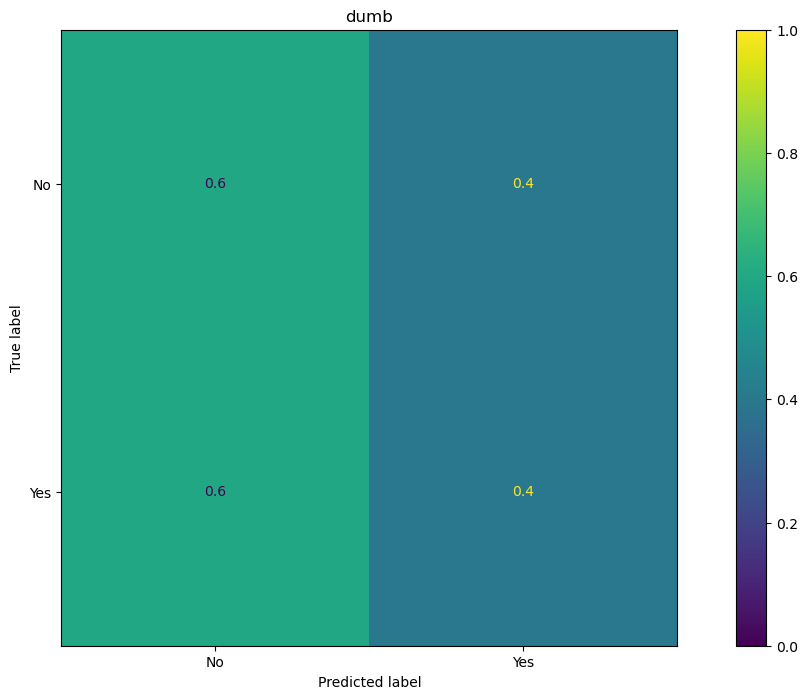

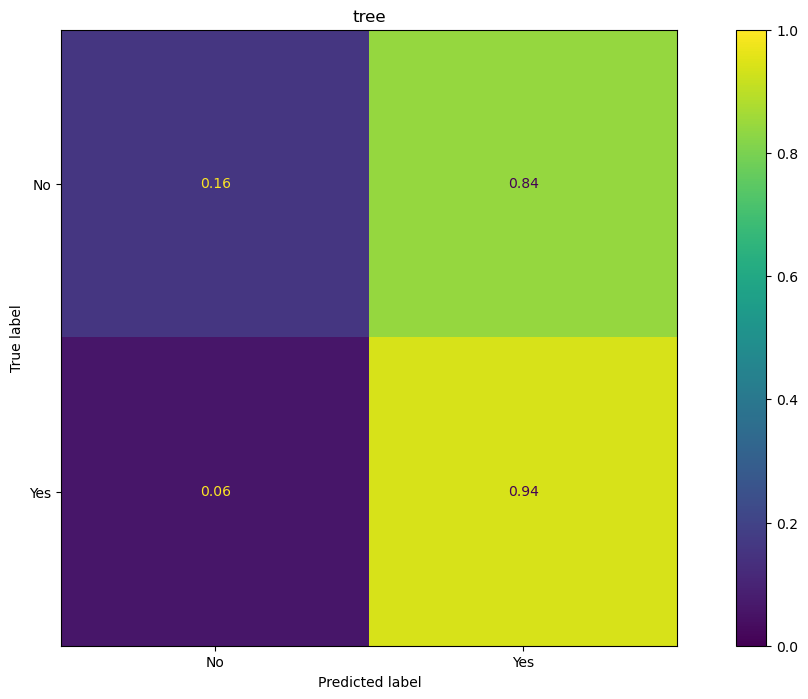

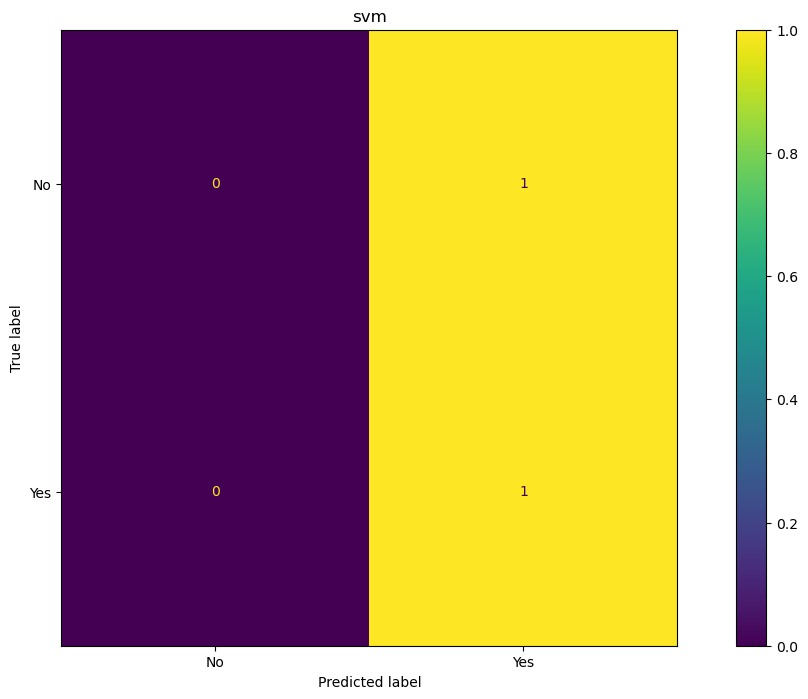

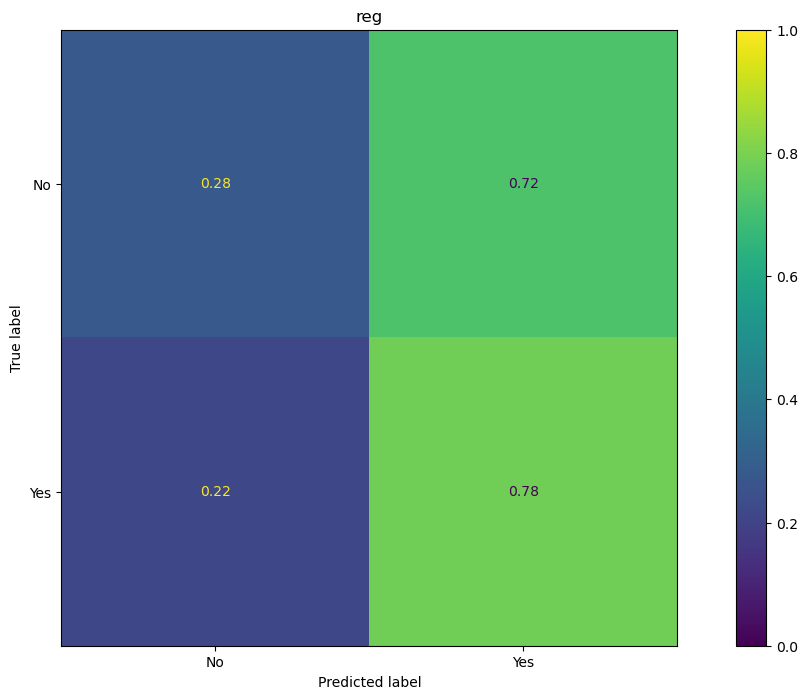

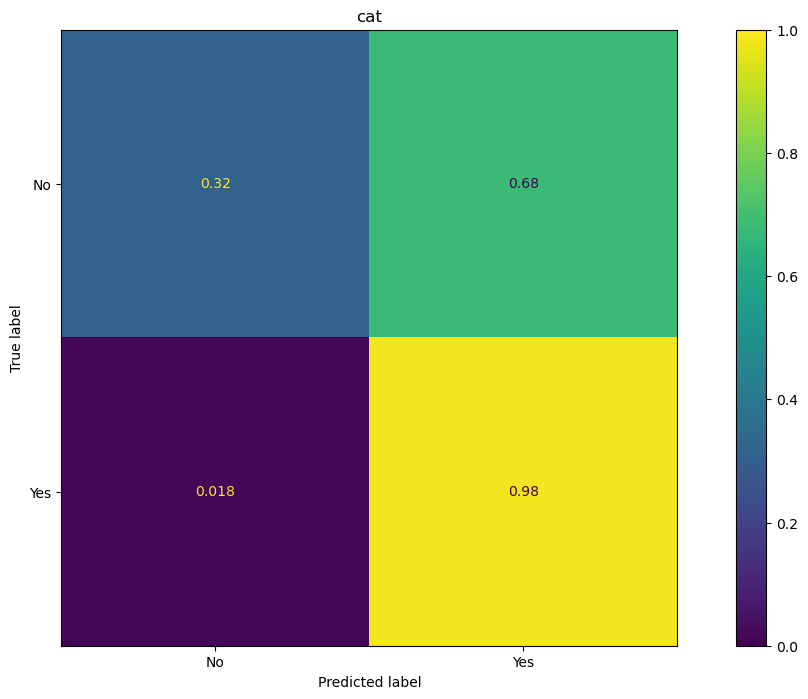

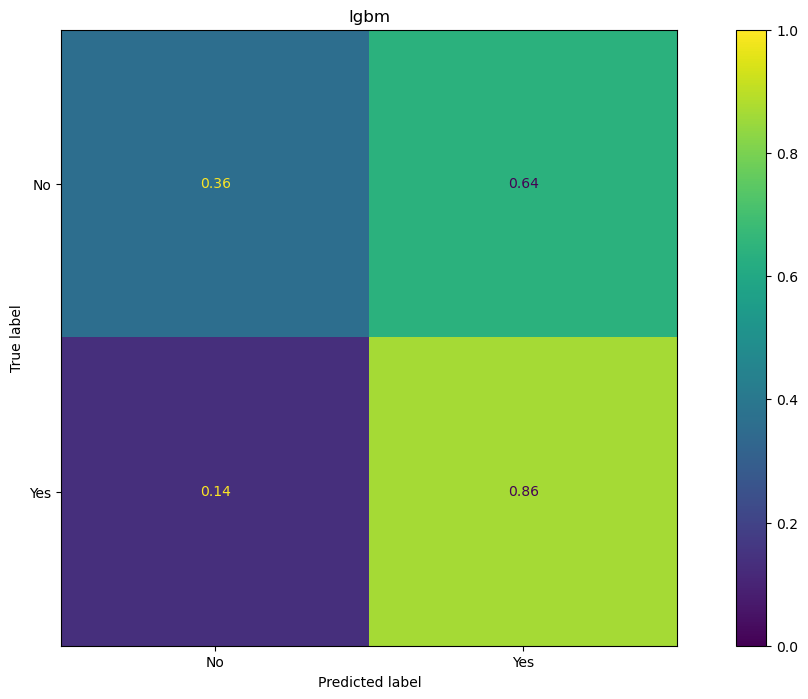

In [328]:
for key in fold_predictions.keys():
    cms = []
    for i, y_pred in enumerate(tqdm(fold_predictions[key])):
        cm = confusion_matrix(y_test_folds[i], y_pred, normalize="true") # normalize over true values
        cms.append(cm)
    cms = np.asarray(cms)
    
    fig, ax = plt.subplots(figsize = (15,8))
    disp = ConfusionMatrixDisplay(confusion_matrix=np.mean(cms,axis=0),display_labels=labels,)
    ax.set_title(key)
    disp.plot(ax=ax)
    disp.ax_.get_images()[0].set_clim(0, 1)

(1610,)
(1610,)
(1610,)


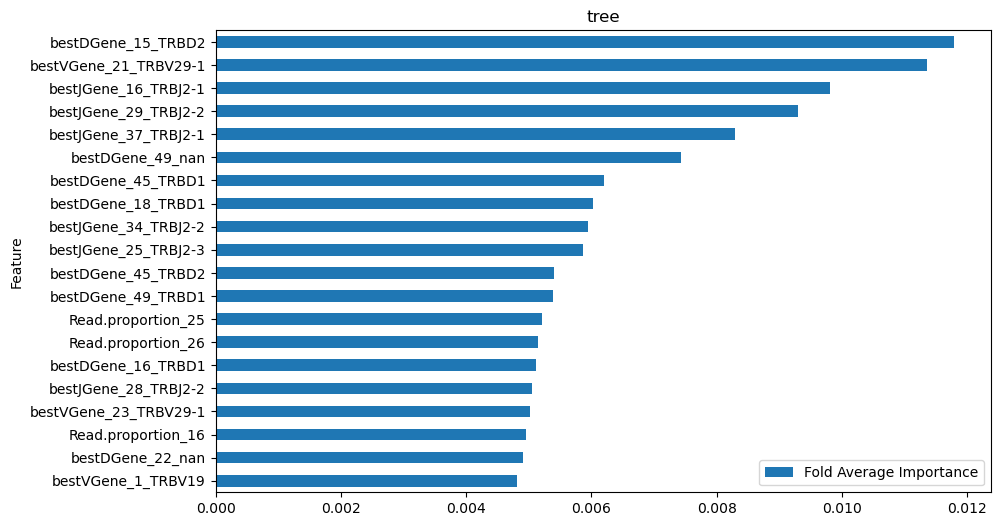

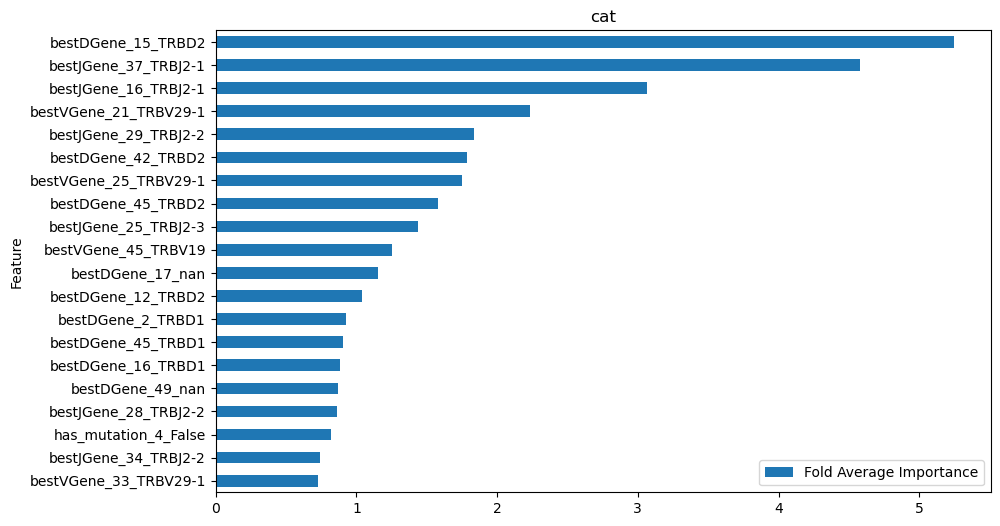

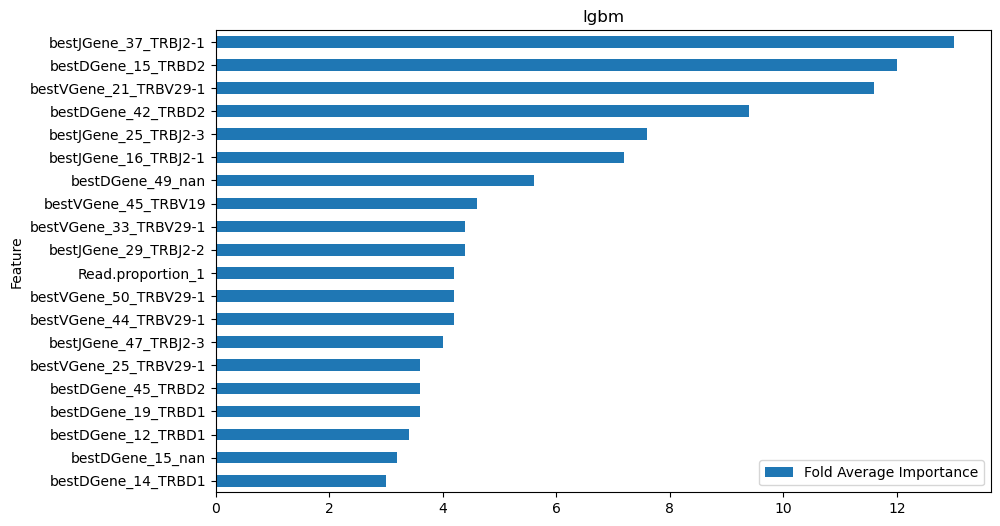

In [329]:
for key in ["tree", "cat", "lgbm"]:
    mean_coef = np.mean(np.asarray(coefficients[key]), axis=0)
    print(mean_coef.shape)
    palette = sns.color_palette(palette='Blues')
    
    fig, ax = plt.subplots(figsize=(10, 6))
    feature_importance = pd.DataFrame({'Feature': X_train.columns, 'Importance': mean_coef})
    feature_importance = feature_importance.sort_values('Importance', ascending=True)
    feature_importance.iloc[-20:].plot(x='Feature', y='Importance', kind='barh', ax=ax, label = "Fold Average Importance")
    
    #for i, cof in enumerate(coefficients[key]):
    #    feature_importance_i = pd.DataFrame({'Feature': X_train.columns, 'Importance': cof})
    #    feature_importance_i = feature_importance_i.sort_values('Importance', ascending=True)
    #    feature_importance_i.iloc[-20:].plot(x='Feature', y='Importance', kind='barh', ax=ax, color =palette[i], alpha=0.4, label="", legend=False)
    ax.set_title(key)
